In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

2024-06-11 19:46:56.792489: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 19:46:56.826933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 19:46:56.826961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 19:46:56.828036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 19:46:56.834170: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 19:46:56.835110: I tensorflow/core/platform/cpu_feature_guard.cc:1

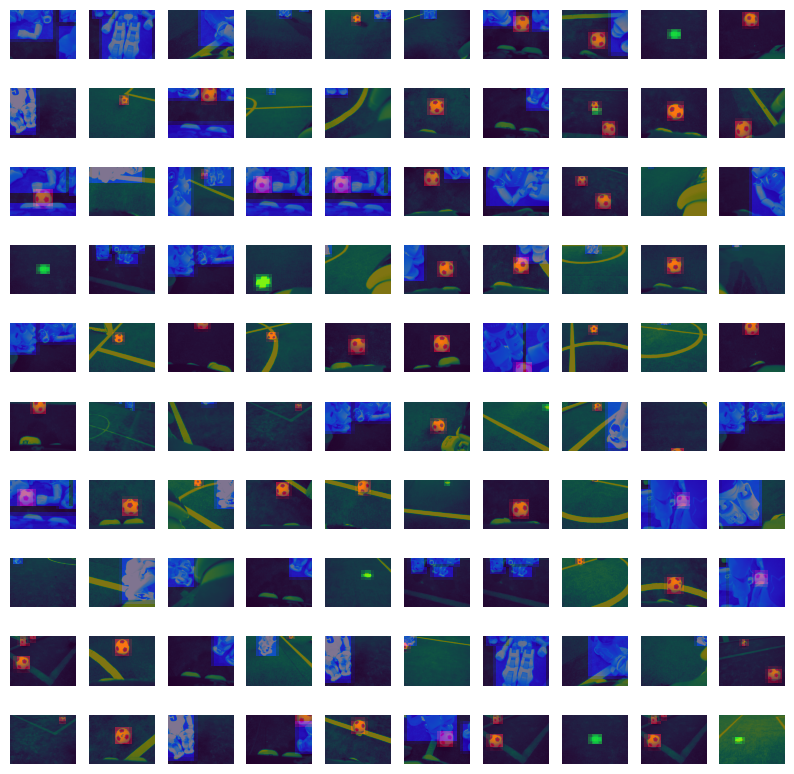

In [2]:
with h5py.File("training_ds_y.h5", "r") as f:
    image = f['X'][0]
    mask = f['Y'][0]
    mask = cv2.resize(mask, (320,240))
    image_height, image_width, _ = image.shape

    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(100):
        image = f['X'][i]
        mask = f['Y'][i]
        ax = axs[i // 10, i % 10]
    
        ax.imshow(image, extent=(0,image_width,0,image_height))
        ax.imshow(mask, extent=(0,image_width,0,image_height), alpha=0.5)
        ax.axis("off")
    plt.show()

In [8]:
from PIL import Image as PIL_Image
def load_image_as_yuv422_y_only(image_filename):
    im = PIL_Image.open(image_filename)
    ycbcr = im.convert('YCbCr')
    reversed_yuv888 = np.ndarray(480 * 640 * 3, 'u1', ycbcr.tobytes())
    full_image_y = reversed_yuv888[0::3]
    full_image_y = full_image_y.reshape(480,640,1)
    half_image_y = full_image_y[::2, ::2]
    
    return half_image_y

1/1 [==============================] - 0s 221ms/step


(0.0, 320.0, 0.0, 240.0)

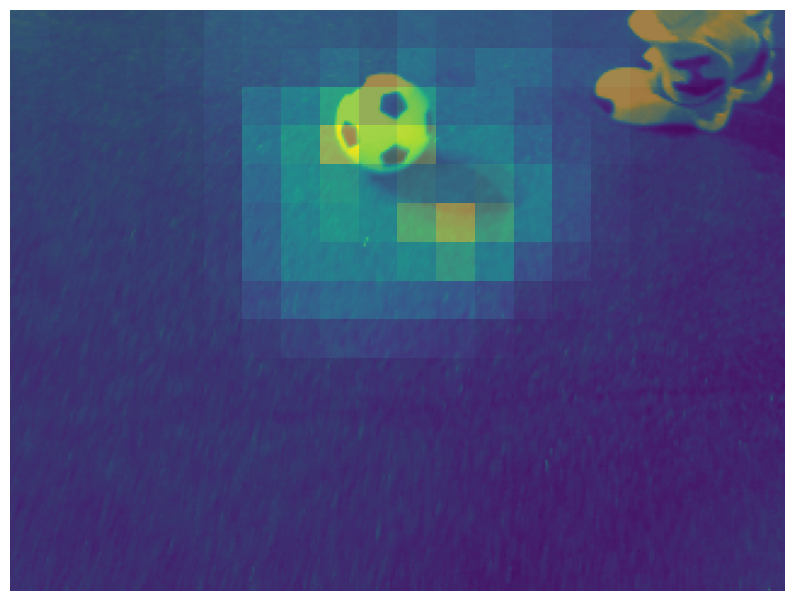

In [19]:
new_model = tf.keras.models.load_model('semantic_segmentation_y-500epochs-augmentation-new.keras')
import numpy as np
import matplotlib.pyplot as plt

# load image from dataset
with h5py.File("training_ds_y.h5", "r") as f:
    image = f['X'][4]
    label = f['Y'][4]

image_input = np.expand_dims(image, axis=0)
result = new_model.predict(image_input)

#print(np.max(result[0,:,:,2]))
#print(result[0,:,:,0])

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
ax = axs
ax.imshow(image, extent=(0,image_width,0,image_height))
ax.imshow(result[0,:,:,0], extent=(0,image_width,0,image_height), alpha=0.5)
ax.axis("off")

In [15]:
class TFLiteModel:
    def __init__(self, model_path: str):
        self.interpreter = tf.lite.Interpreter(model_path)
        self.interpreter.allocate_tensors()

        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def predict(self, *data_args):
        assert len(data_args) == len(self.input_details)
        for data, details in zip(data_args, self.input_details):
            self.interpreter.set_tensor(details["index"], data)
        self.interpreter.invoke()
        return self.interpreter.get_tensor(self.output_details[0]["index"])
    
from naoth.log import Reader as LogReader
game_logs = ["10.log"]
log_image = 1
for log_num, game_log in enumerate(game_logs):
    count = 0
    with LogReader(str(game_log)) as gamelog_reader:
        for frame in gamelog_reader.read():
            count += 1
            message = frame["Image"]

            # read each channel of yuv422 separately
            yuv422 = np.frombuffer(message.data, dtype=np.uint8)
            y = yuv422[0::2]
            full_image_y = y.reshape(480,640,1)
            half_image_y = full_image_y[::2, ::2]
            log_image = half_image_y / 255.0
            break

(240, 320, 1)
(1, 240, 320, 1)
[0.29411766 0.32156864 0.40784314 0.41960785 0.42352942 0.43137255
 0.45882353 0.42352942 0.41960785 0.36862746]
(15, 20, 3)
[2.7867012e-05 1.7772940e-05 4.6226382e-03 2.2872335e-07 4.2283881e-07
 3.0842013e-04 3.1460104e-08 3.8177812e-09 7.6617951e-05 7.4938278e-08]


(0.0, 320.0, 0.0, 240.0)

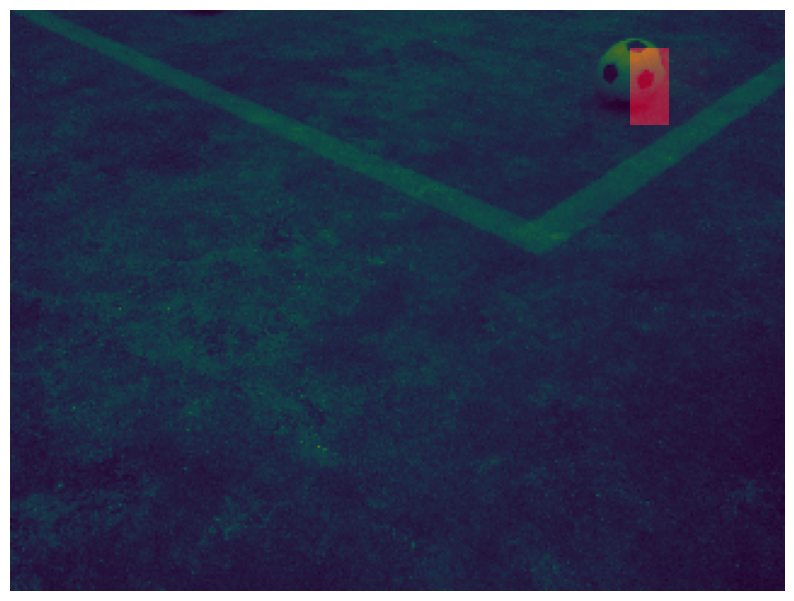

In [36]:
model = TFLiteModel("semantic_segmentation_y.tflite")
#image_orig = load_image_as_yuv422_y_only("0205141.png")  # FIXME
my_image = log_image
print(my_image.shape)

image_width, image_height, _ = my_image.shape
#image = image_orig / 255.0
my_image = my_image.astype(np.float32)[np.newaxis]
print(my_image.shape)
print(my_image.ravel()[0:10])
label = model.predict(my_image)[0]
#print(label)
print(label.shape)

print(label.ravel()[0:10])


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
ax = axs
ax.imshow(log_image, extent=(0,320,0,240))
ax.imshow(label, extent=(0,320,0,240), alpha=0.5)
ax.axis("off")

In [48]:
#print(label[-2,:,0])
for i in range(15):
    #print(label[i,:,0])
    sum = np.sum(label[i,:,0])
    print(i, sum)
    if sum > 1.0:
        print(label[i,:,0])
print()
print(label.ravel()[60:80])

0 0.001195884
1 1.088039
[6.2577044e-07 3.6547978e-09 1.9454220e-09 1.6261648e-09 2.2601578e-09
 4.2514783e-09 8.7162491e-09 1.1861108e-06 1.0229792e-05 4.0330869e-07
 1.8592873e-08 2.0275348e-09 5.3453253e-10 7.4819811e-10 3.6090148e-07
 3.5632513e-02 9.9724376e-01 5.3463221e-02 1.6021156e-03 8.4538777e-05]
2 1.0533717
[2.0889945e-07 1.6727100e-10 6.1157156e-11 9.8977646e-11 8.9778468e-10
 1.9002703e-08 5.0149729e-09 3.2506975e-06 1.4192312e-05 3.2776713e-06
 4.7099650e-08 3.3033793e-08 1.0035136e-08 2.4465661e-08 3.9112900e-05
 3.4110021e-02 9.9146050e-01 2.2524215e-02 4.7922940e-03 4.2439494e-04]
3 0.015181831
4 9.835832e-06
5 3.8311377e-06
6 4.1476975e-05
7 8.5764526e-07
8 2.006445e-06
9 1.9710874e-06
10 1.2684747e-05
11 0.00030765447
12 0.00027833183
13 8.90226e-05
14 0.0006605463

[6.2577044e-07 3.0705061e-05 1.6482938e-04 3.6547978e-09 4.6231585e-07
 2.1677770e-06 1.9454220e-09 3.9088390e-09 1.6021370e-06 1.6261648e-09
 5.3336496e-08 2.9807054e-06 2.2601578e-09 5.7932206e-09 4.7

In [52]:
for i in label.flatten():
    
    print(i)

2.7867012e-05
1.777294e-05
0.004622638
2.2872335e-07
4.228388e-07
0.00030842013
3.1460104e-08
3.817781e-09
7.661795e-05
7.493828e-08
6.770891e-10
9.144517e-05
4.019705e-08
1.2699636e-09
5.1575666e-05
3.971056e-08
4.841116e-10
4.1288837e-05
3.3487954e-08
3.687742e-10
2.0085497e-05
6.357879e-08
4.261418e-08
1.1507409e-05
2.7578412e-07
2.480226e-08
2.1732583e-05
2.5567036e-07
8.4084554e-08
3.0702573e-05
8.681742e-08
2.396044e-08
7.8239114e-05
6.79691e-07
9.098022e-08
0.000119686316
1.1149192e-07
2.4475173e-09
2.0068455e-05
1.02506256e-07
9.377273e-11
2.712473e-05
6.7198897e-07
6.664449e-12
5.992746e-06
0.00013514615
2.7351862e-10
4.8987235e-06
0.0008629756
5.2823106e-12
9.3500205e-07
5.057176e-06
1.0140249e-15
2.734822e-06
1.7371738e-05
1.9832298e-15
2.8343982e-05
0.00014477027
1.2854782e-08
0.0015100922
6.2577044e-07
3.070506e-05
0.00016482938
3.6547978e-09
4.6231585e-07
2.167777e-06
1.945422e-09
3.908839e-09
1.602137e-06
1.6261648e-09
5.3336496e-08
2.9807054e-06
2.2601578e-09
5.7932206e